In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA

In [5]:
customers = pd.read_csv('Customers.csv')
transaction = pd.read_csv('Transactions.csv')

In [7]:
# Merge datasets on CustomerID
merged_data = pd.merge(customers, transaction, on='CustomerID')

In [9]:
merged_data.head(1)

,CustomerID,CustomerName,Region,SignupDate,TransactionID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,C0001,Lawrence Carroll,South America,2022-07-10,T00015,P054,2024-01-19 03:12:55,2,114.6,57.3


In [17]:
# Ensure 'SignupDate' is in datetime format
merged_data['SignupDate'] = pd.to_datetime(merged_data['SignupDate'])
# Calculate days since joining
merged_data['DaysSinceJoining'] = (pd.to_datetime('today') - merged_data['SignupDate']).dt.days

In [19]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        1000 non-null   object        
 1   CustomerName      1000 non-null   object        
 2   Region            1000 non-null   object        
 3   SignupDate        1000 non-null   datetime64[ns]
 4   TransactionID     1000 non-null   object        
 5   ProductID         1000 non-null   object        
 6   TransactionDate   1000 non-null   object        
 7   Quantity          1000 non-null   int64         
 8   TotalValue        1000 non-null   float64       
 9   Price             1000 non-null   float64       
 10  DaysSinceJoining  1000 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 86.1+ KB


In [27]:
# Merge customer profile data
final_data = pd.merge(customer_data, customers, on='CustomerID')
# Select features for clustering
features = final_data[['TotalSpend', 'TransactionFrequency', 'TotalQuantity']]

In [29]:

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

## Apply Clustering

In [40]:
# Test different cluster numbers (2 to 10) and evaluate DB Index
db_scores = []
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)

    # Calculate Davies-Bouldin Index
    db_index = davies_bouldin_score(scaled_features, clusters)
    db_scores.append(db_index)

    # Calculate Silhouette Score
    silhouette = silhouette_score(scaled_features, clusters)
    silhouette_scores.append(silhouette)

# Optimal number of clusters
optimal_k = 2 + db_scores.index(min(db_scores))
print(f"Optimal number of clusters: {optimal_k}")

Optimal number of clusters: 2


In [48]:
# Calculate DB Index
db_index = davies_bouldin_score(scaled_features, kmeans.labels_)
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 0.7233652695141876


In [52]:
# Step 1: Initialize a DataFrame to store results
cluster_results = []

# Step 2: Loop through different numbers of clusters for GridSearch
best_db_index = float('inf')
best_kmeans = None
best_n_clusters = 0

# Try different numbers of clusters (from 2 to 10)
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_features)

    # Calculate Davies-Bouldin Index
    db_index = davies_bouldin_score(scaled_features, kmeans.labels_)

    # Store the result for each iteration
    cluster_results.append({
        'n_clusters': n_clusters,
        'davies_bouldin_index': db_index
    })
# Track the best DBI 
    if db_index < best_db_index:
        best_db_index = db_index
        best_kmeans = kmeans
        best_n_clusters = n_clusters

# Step 3: Convert results to a DataFrame for easier analysis
cluster_results_df = pd.DataFrame(cluster_results)

# Display the results of each trial
cluster_results_df

,n_clusters,davies_bouldin_index
0,2,0.723365
1,3,0.772685
2,4,0.865062
3,5,0.896729
4,6,0.932103
5,7,0.928462
6,8,0.921743
7,9,1.076514
8,10,1.032008


In [74]:
# Calculate Silhouette Score
silhouette_avg = silhouette_score(scaled_features, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.29489336527987503


### The elbow method visualizes inertia to find the optimal number of clusters

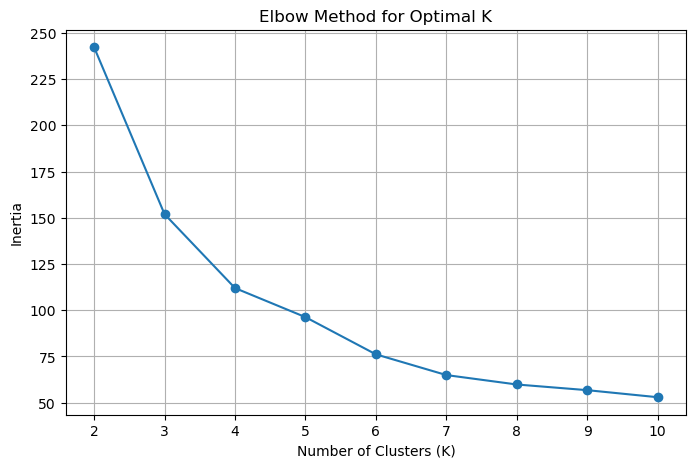

In [76]:
inertias = []
k_values = range(2, 11)  # Try k from 1 to 10
for k in k_values:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(scaled_features)
    inertias.append(model.inertia_)

# Plot inertia vs. number of clusters
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid()
plt.show()

## Visualize DB Index and Silhouette Scores

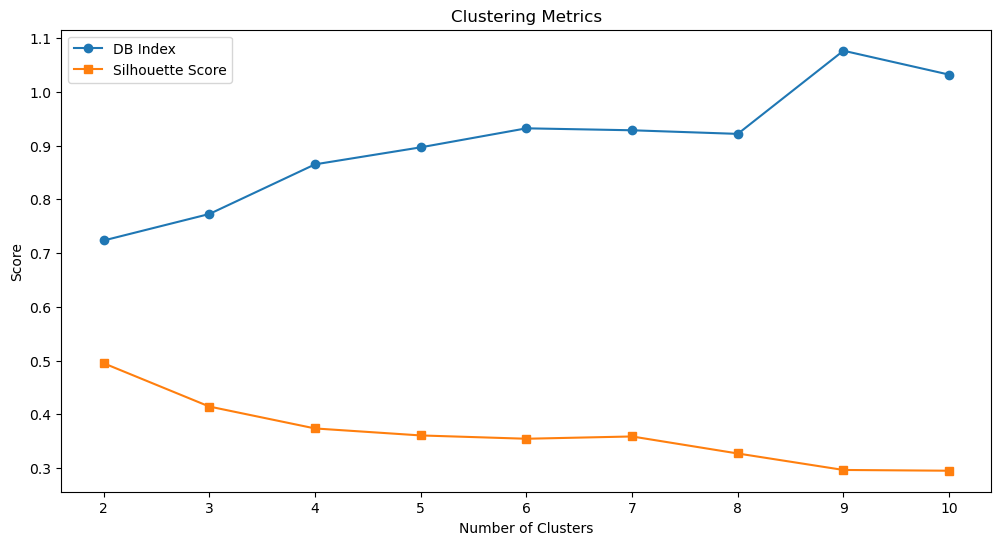

In [43]:
# Plot DB Index and Silhouette Score
plt.figure(figsize=(12, 6))
plt.plot(range(2, 11), db_scores, marker='o', label='DB Index')
plt.plot(range(2, 11), silhouette_scores, marker='s', label='Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Clustering Metrics')
plt.legend()
plt.show()

## Visualize Clusters

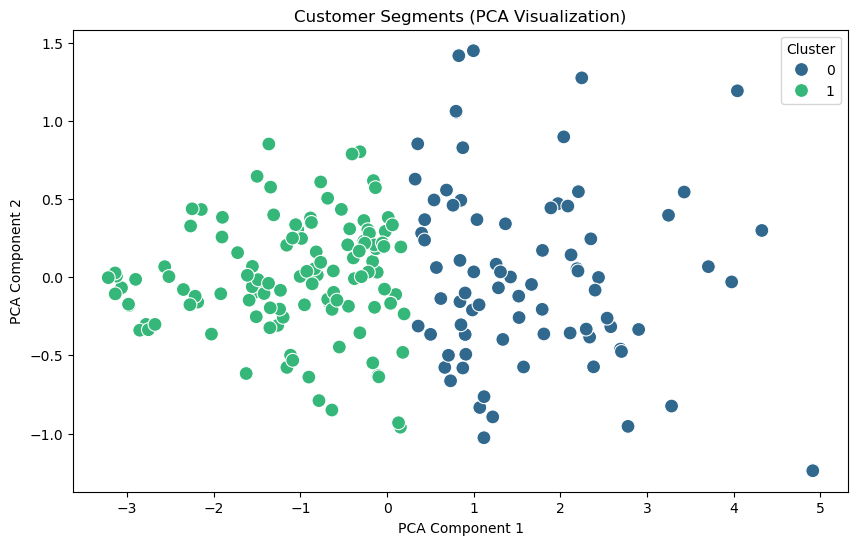

In [46]:
# Apply KMeans with optimal clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
final_data['Cluster'] = kmeans.fit_predict(scaled_features)

# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_features)
final_data['PCA1'] = reduced_data[:, 0]
final_data['PCA2'] = reduced_data[:, 1]

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=final_data,
    x='PCA1',
    y='PCA2',
    hue='Cluster',
    palette='viridis',
    s=100
)
plt.title('Customer Segments (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


## Summary Metrics 

In [72]:
print(f"Number of clusters formed: {optimal_k}")
print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette_avg}")
print(f"Inertia: {kmeans.inertia_}")


Number of clusters formed: 2
Davies-Bouldin Index: 1.0320081943154773
Silhouette Score: 0.29489336527987503
Inertia: 52.96423245462421
